# **Glen Ridge, NJ Housing Data Analysis**

**Question:** How does pricing strategy affect sale price and days on market?

**Hypothesis 1:** Pricing below the average price per square foot will yield a greater sale price because of multiple offers in this competitive market
**Hypothesis 2:** Pricing below the average price per square foot will result in less days on the market

**1. Separate homes sold in 2020 into three categories based on 2019 tax bill**

In [1]:
import pandas as pd

#read in and fill missing values
df=pd.read_csv('Glen Ridge Housing Data.csv')
df['PPSF']=df['Sale_price']//df['SF']
type(df['List_date'][0])
pd.to_datetime('7/7/20', format='%m/%d/%y')
df.loc[16, 'List_date']='4/30/20'
df['List_date']=pd.to_datetime(df['List_date'])
df.loc[16, 'Sale_date']='7/29/20'
df['Sale_date']=pd.to_datetime(df['Sale_date'])
df['Days_on']=df['Sale_date']-df['List_date']
df.drop(['QV'], axis=1, inplace=True)
df['Days_on']= pd.to_numeric(df['Days_on'].dt.days, downcast='integer')

#find categories based on SF and/or tax
df['Tax_year_prior_sale']=df['Tax_year_prior_sale'].str.replace(',', '').astype(float)
df['Size_label']=pd.qcut(df['Tax_year_prior_sale'], 3, labels=["small", "medium","large"])




**2. Calculate average price per square foot within each category
3. Normalize list price and sale price around average per category**

In [2]:
df_small=df.where(df['Size_label']=='small').dropna()
df_medium=df.where(df['Size_label']=='medium').dropna()
df_large=df.where(df['Size_label']=='large').dropna()
av_ppsf_small=df_small['PPSF'].sum()/len(df_small)
print('Average sold price per square foot for small homes:', av_ppsf_small)

df_small['OLP_Diff']=(df_small['OLP']/df_small['SF'])-av_ppsf_small
df_small['Sale_Diff']=(df_small['Sale_price']/df_small['SF'])-av_ppsf_small

av_ppsf_medium=df_medium['PPSF'].sum()/len(df_medium)
print('Average sold price per square foot for medium homes:',av_ppsf_medium)

df_medium['OLP_Diff']=(df_medium['OLP']/df_medium['SF'])-av_ppsf_medium
df_medium['Sale_Diff']=(df_medium['Sale_price']/df_medium['SF'])-av_ppsf_medium

av_ppsf_large=df_large['PPSF'].sum()/len(df_large)
print('Average sold price per square foot for large homes:',av_ppsf_large) 

df_large['OLP_Diff']=(df_large['OLP']/df_large['SF'])-av_ppsf_large
df_large['Sale_Diff']=(df_large['Sale_price']/df_large['SF'])-av_ppsf_large



Average sold price per square foot for small homes: 330.84615384615387
Average sold price per square foot for medium homes: 338.46153846153845
Average sold price per square foot for large homes: 340.5


**3. Plot scatterplot of normalized list price (x-axis) to normalized sale price (y-axis) for each category**

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress


LinregressResult(slope=0.875296123570748, intercept=14.544387412799894, rvalue=0.7598779128024932, pvalue=0.002577165298955217, stderr=0.22577308463628354)

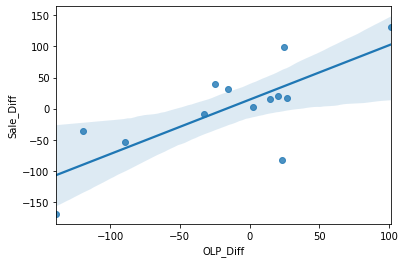

In [4]:
sns.regplot(x="OLP_Diff", y="Sale_Diff", data=df_small)
linregress(df_small['OLP_Diff'], df_small['Sale_Diff'])

LinregressResult(slope=1.1712971720548881, intercept=44.9341628446763, rvalue=0.893034384192589, pvalue=3.958917847533409e-05, stderr=0.17795242906053046)

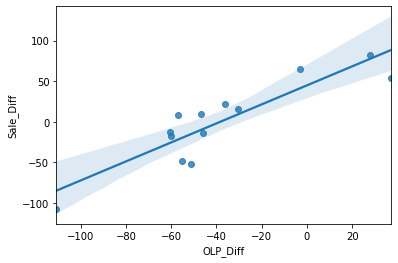

In [5]:
sns.regplot(x="OLP_Diff", y="Sale_Diff", data=df_medium)
linregress(df_medium['OLP_Diff'], df_medium['Sale_Diff'])

LinregressResult(slope=0.6357504074517261, intercept=9.49942313383085, rvalue=0.7114848164959018, pvalue=0.009462685368687367, stderr=0.19856004967181723)

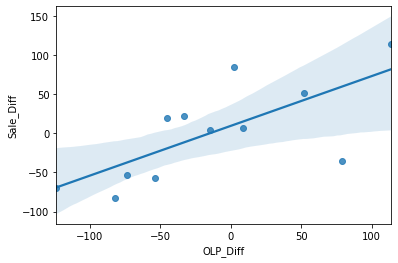

In [6]:
sns.regplot(x="OLP_Diff", y="Sale_Diff", data=df_large)
linregress(df_large['OLP_Diff'], df_large['Sale_Diff'])

**All three categories have high r-values. This shows correlation between list price and sale price. In the small and large categories the slope is <1, meaning a higher list price does not yield an equally higher sale price. The medium category shows a slope >1 but has some extreme outliers. Perhaps a better analysis should use smaller categories to deal with this issue.**

**4. Plot normalized list price vs. days on market for each of the three categories.**

LinregressResult(slope=-0.011753311071565742, intercept=134.96758704484398, rvalue=-0.0044995411762172605, pvalue=0.988360493145963, stderr=0.7875738019152299)

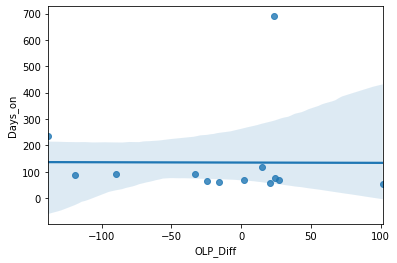

In [7]:
#Days on market vs. OLP_Diff
sns.regplot(x='OLP_Diff', y='Days_on', data=df_small)
linregress(df_small['OLP_Diff'], df_small['Days_on'])

LinregressResult(slope=-1.29623181659312, intercept=47.67921597024239, rvalue=-0.5896548110493561, pvalue=0.03392213366908819, stderr=0.5353213637111482)

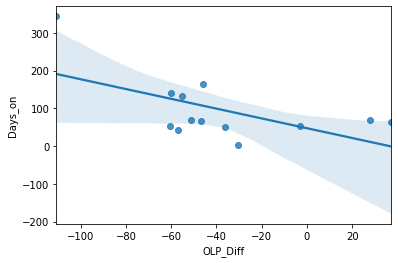

In [8]:
sns.regplot(x="OLP_Diff", y="Days_on", data=df_medium)
linregress(df_medium['OLP_Diff'], df_medium['Days_on'])

LinregressResult(slope=0.38047168317197655, intercept=122.20868432346552, rvalue=0.3489007145156811, pvalue=0.2663351177287103, stderr=0.3231722653787115)

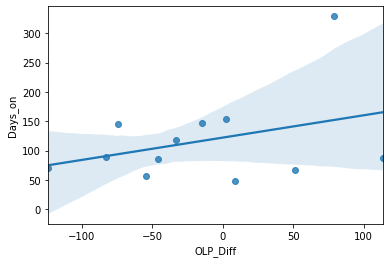

In [9]:
sns.regplot(x='OLP_Diff', y='Days_on', data=df_large)
linregress(df_large['OLP_Diff'], df_large['Days_on'])

The low r-values in all three graphs show that there is little correlation between normalized list price and days on market. This will be explored further below with smaller bin sizes for tax categories.

**5. Cut data into smaller bins. Plot each data point normalized to the average price per square foot for its new category, on one graph.**

In [10]:
#make smaller categories to evaluate av. PPSF
df['Size_label']=pd.qcut(df['Tax_year_prior_sale'], 10, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
df_new = df.groupby(['Size_label']).agg({'PPSF': 'sum', 'Address': 'count'}) 
df_1=pd.merge(df, df_new, on='Size_label')
df_1['Av_PPSF_by_cat']=df_1['PPSF_y']/df_1['Address_y']

df_1['OLP_Diff']=(df_1['OLP']/df_1['SF'])-df_1['Av_PPSF_by_cat']
df_1['Sale_Diff']=(df_1['Sale_price']/df_1['SF'])-df_1['Av_PPSF_by_cat']
df_1.dropna(inplace=True)

LinregressResult(slope=0.700818878114606, intercept=16.560072876750958, rvalue=0.688492595994941, pvalue=1.7716693258218512e-06, stderr=0.12303793525488159)

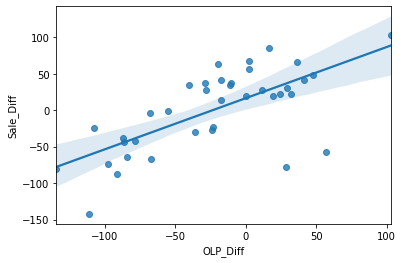

In [11]:
sns.regplot(x="OLP_Diff", y="Sale_Diff", data=df_1)
linregress(df_1['OLP_Diff'], df_1['Sale_Diff'])

**6. Using the new categories, compare normalized list price to days on market**

LinregressResult(slope=0.03927504785326317, intercept=117.14149149621242, rvalue=0.018039248503860718, pvalue=0.9143960364257087, stderr=0.36280758397567703)

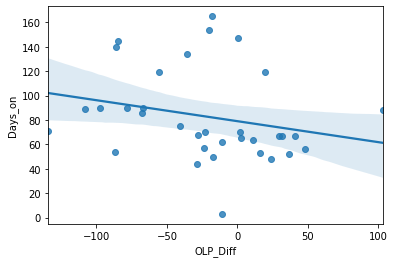

In [12]:
df_new1=df_1.where(df_1["Days_on"]<200).dropna()
sns.regplot(x="OLP_Diff", y="Days_on", data=df_new1)
linregress(df_1['OLP_Diff'], df_1['Days_on'])

## **Conclusions:** 

**Using smaller bin sizes (to more accurately compare similar homes), there is a reasonably strong correlation between normalized list price and normalized sale price (r-value of 0.69). This is intuitive because homes that have upgrades (better features, additional usable space, location) will likely list and sell above the average price per square foot. The slope of the regression in section 5 is 0.70, meaning that an increase in list price per square foot does not equate to a comparable increase in sale price per square foot. There appears to be a "sweet spot" with a cluster of homes listed just below the average but selling above average. This is explored further below.**

**In section 6 normalized list price is compared to days on market to test the hypothesis that a list price below the average price per square foot will cause a home to sell faster. This is disproven by the low correlation (r-value of 0.02) and overall downward trend.** 

In [18]:
df_1.head()
df_2=df_1.filter(['Av_PPSF_by_cat', 'OLP_Diff', 'Sale_Diff'], axis=1)
df_2.head()

two_pos=df_2[(df_2['OLP_Diff']>=0) & (df_2['Sale_Diff']>=0)]
two_pos.insert(0, 'Hue', 'Listed above, sold above')

one_pos=df_2[(df_2['OLP_Diff']>=0) & (df_2['Sale_Diff']<0)]
one_pos.insert(0, 'Hue', 'Listed above, sold below')

one_neg=df_2[(df_2['OLP_Diff']<0) & (df_2['Sale_Diff']>=0)]
one_neg.insert(0, 'Hue', 'Listed below, sold above')

two_neg=df_2[(df_2['OLP_Diff']<0) & (df_2['Sale_Diff']<0)]
two_neg.insert(0, 'Hue', 'Listed below, sold below')

final_df=pd.concat([two_pos, one_pos, one_neg, two_neg], axis=0).reset_index(drop=True)


In [14]:
import altair as alt

In [15]:
alt.renderers.enable('default')

RendererRegistry.enable('default')

In [16]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [44]:
points=alt.Chart(final_df).mark_point(filled=True, size=150).encode(
    x=alt.X('OLP_Diff', title='List Price Difference from Average'),
    y=alt.Y('Sale_Diff', title='Sale Price Difference from Average'),
    color=alt.Color('Hue', title=None)
)

horizline = alt.Chart().mark_rule().encode(
    y='a:Q'
)
vertline = alt.Chart().mark_rule().encode(
    x='a:Q'
)

chart=alt.layer(
    points, horizline, vertline,
    data=final_df
).transform_calculate(
    a="0"
)

chart.properties(title='Glen Ridge Housing Data: 2020 Sales'
).configure_title(offset=20, fontSize=20)

alt.LayerChart(...)